<a href="https://colab.research.google.com/github/rishubhkhurana/EVA/blob/master/S7/S7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries 

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.utils as vutils
import numpy as np
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from vision_dataloaders import *
from plots import show_batch
from layers import *
from torchsummary import summary
from train import *
from tqdm import tqdm_notebook
from test import *
from torch.optim.lr_scheduler import StepLR

## Dataset/Dataloader

In [0]:
tfms = create_transform(['tensor'])

In [4]:
data = VisionData(name='CIFAR10').load(tfms=tfms,train=True)

Extracting ./data/cifar-10-python.tar.gz to ./data


In [0]:
n = data.data.copy()

In [0]:
n = n/255.

In [0]:
u,s=np.mean(n,(0,1,2)),np.std(n,(0,1,2))


In [8]:
u,s

(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [0]:
tfms = create_transform(tfm_names=['rotate','hflip','tensor','normalize'],norm_constants=[u,s],angle=10)

In [10]:
trn_data = VisionData(name='CIFAR10').load(tfms=tfms,train=True)

Files already downloaded and verified


In [0]:
tfms = create_transform(tfm_names=['tensor','normalize'],norm_constants=[u,s])

In [12]:
val_data = VisionData(name='CIFAR10').load(tfms=tfms,train=False)

Files already downloaded and verified


In [13]:
len(val_data)

10000

In [0]:
is_CUDA = torch.cuda.is_available()
SEED = 111
bs=32*4
torch.manual_seed(SEED)
dev = torch.device('cuda' if is_CUDA else 'cpu')
dataloader_args = dict(shuffle=True,num_workers=4,batch_size=bs) if is_CUDA else dict(shuffle=True,batch_size=bs)
trn_dl = getDataLoader(trn_data,**dataloader_args)
dataloader_args = dict(shuffle=False,num_workers=4,batch_size=2*bs) if is_CUDA else dict(shuffle=True,batch_size=bs)
val_dl = getDataLoader(val_data,**dataloader_args)

## Plotting Images

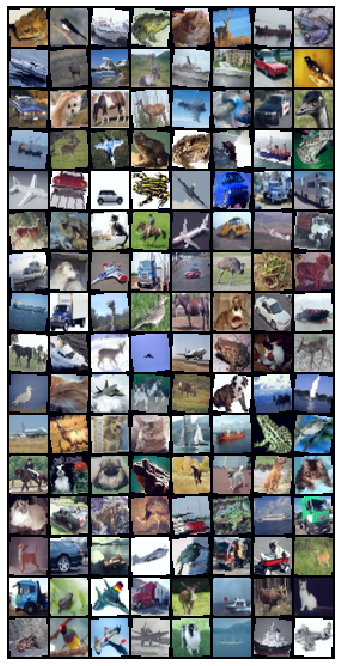

In [15]:
show_batch(trn_dl)

## Model 

In [0]:
lyr = get_conv(3,16,conv_typ='depthwise',kernel_per_layer=4,kernel_size=(1,1))

In [17]:
lyr

DepthConv(
  (lyrs): Sequential(
    (0): ConvLayer(
      (lyrs): Sequential(
        (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3)
      )
    )
    (1): ConvLayer(
      (lyrs): Sequential(
        (0): Conv2d(12, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
  )
)

In [0]:
cblocks = {}
cblocks['1']=prepare_convblock(channels=[32,64])
cblocks['2']=prepare_convblock(channels=[64,64])
cblocks['3']=prepare_convblock(channels=[128,128])
cblocks['4']=prepare_convblock(channels=[256,256])


In [0]:
tblocks = {}
tblocks['1']=prepare_convblock(types=['regular'],channels=[16],ks=[1])
tblocks['2']=prepare_convblock(types=['regular'],channels=[32],ks=[1])
tblocks['3']=prepare_convblock(types=['regular'],channels=[64],ks=[1])


In [0]:
class CNNModel(nn.Module):
    def __init__(self,inch=3,cblocks={},tblocks={},out_blocks=[],nc=10):
        super().__init__()
        assert len(cblocks)>0
        assert len(tblocks)>len(cblocks)-1
        for blocknum,values in cblocks.items():
            lyrs=[]
            if blocknum==1:
                in_channels=inch
            for typ,ch,ks in values:
                if typ=='depthwise':
                    lyrs.append(get_conv(in_channels,ch,conv_typ='depthwise',
                                         first_kernel_size=ks,kernel_size=(1,1)))
                else:
                    lyrs.append(get_conv(in_channels,ch,conv_typ='regular',
                                         kernel_size=(ks,ks)))                    
            
        

In [0]:
class FirstModel(nn.Module):
    def __init__(self,p=0.1):
        super().__init__()
        # First Conv Block -- edges and gradients
        cblock1 =[]
        cblock1.append(get_conv(3,32,drop=True,p=p,conv_typ='depthwise',kernel_size=(1,1)))# 32,32,3
        cblock1.append(get_conv(32,64,drop=True,p=p))# 32,32,5
        self.cblock1 = nn.Sequential(*cblock1)
        tblock1=[]
        tblock1.append(nn.MaxPool2d((2,2)))# 32,16,6
        tblock1.append(get_conv(64,16,kernel_size=(1,1),drop=True,p=p))# 16,16,6 
        self.tblock1 = nn.Sequential(*tblock1)
        # Second Conv block -- textures and patterns
        cblock2 =[]
        cblock2.append(get_conv(16,64,drop=True,p=p,dilation=2))# 16,16,14
        cblock2.append(get_conv(64,64,drop=True,p=p))# 16,16,18
        self.cblock2 = nn.Sequential(*cblock2)
        tblock2=[]
        tblock2.append(nn.MaxPool2d((2,2)))# 8,8,20
        tblock2.append(get_conv(64,16,kernel_size=(1,1),drop=True,p=p))# 8,8,20
        self.tblock2 = nn.Sequential(*tblock2)
        # Third Conv block -- part of objects 
        cblock3 =[]
        cblock3.append(get_conv(16,128,drop=True,p=p))# 8,8,28
        cblock3.append(get_conv(128,128,drop=True,p=p))# 8,8,36
        self.cblock3 = nn.Sequential(*cblock3)
        tblock3=[]
        tblock3.append(nn.MaxPool2d((2,2)))# 8,4,40
        tblock3.append(get_conv(128,32,kernel_size=(1,1),drop=True,p=p))# 4,4,40
        self.tblock3 = nn.Sequential(*tblock3)
        # Fourth Conv block -- objects
        cblock4 =[]
        cblock4.append(get_conv(32,256,drop=True,p=p))# 4,4,56
        #cblock4.append(get_conv(256,256))
        self.cblock4 = nn.Sequential(*cblock4)
        self.tblock4 = nn.AdaptiveAvgPool2d(1)
        #self.conv_blocks = nn.Sequential(self.cblock1,self.tblock1,self.cblock2,self.tblock2
        #                                 ,self.cblock3,self.tblock3,self.cblock4,self.tblock4)
        self.out_block = nn.Conv2d(256,10,kernel_size=(1,1))
        self.nc = 10
    def forward(self,x):
        x = self.cblock1(x)
        x = self.tblock1(x)
        x = self.cblock2(x)
        x = self.tblock2(x)
        x = self.cblock3(x)
        x = self.tblock3(x)
        x = self.cblock4(x)
        x = self.tblock4(x)
        x = self.out_block(x)
        
        return x.view(-1,self.nc)
        

In [0]:
mod = FirstModel()

In [0]:
#mod

In [24]:
summary(mod.to(dev),input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              30
         ConvLayer-2            [-1, 3, 32, 32]               0
            Conv2d-3           [-1, 32, 32, 32]             128
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
         ConvLayer-7           [-1, 32, 32, 32]               0
         DepthConv-8           [-1, 32, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          18,496
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
          Dropout-12           [-1, 64, 32, 32]               0
        ConvLayer-13           [-1, 64, 32, 32]               0
        MaxPool2d-14           [-1, 64,

## Training 

In [0]:
mod = FirstModel(p=0.05).to(dev)

In [0]:
lr=4e-3
opt = optim.SGD(mod.parameters(),lr=lr,momentum=0.9)
#sched = StepLR(opt,10,gamma=0.2)

In [0]:
dls={}
dls['train']=trn_dl
dls['valid']=val_dl

In [0]:
EPOCHS=30
loss_func=nn.CrossEntropyLoss()

In [0]:
#opt.param_groups[0]['lr']=1e-4

In [29]:
res=train(mod,opt,dls,loss_func=loss_func,n_epochs=40,device=dev)#,scheduler=sched)

Training Loss:1.306, Training Acc:48.750: 100%|██████████| 391/391 [00:17<00:00, 29.00it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[0/40]--> Training Loss:1.600, Training Accuracy:40.480, Validation Loss:1.425, Validation Accuracy:48.050


Training Loss:1.133, Training Acc:57.500: 100%|██████████| 391/391 [00:16<00:00, 29.21it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[1/40]--> Training Loss:1.211, Training Accuracy:56.280, Validation Loss:1.088, Validation Accuracy:60.850


Training Loss:0.873, Training Acc:65.000: 100%|██████████| 391/391 [00:16<00:00, 23.03it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[2/40]--> Training Loss:1.037, Training Accuracy:63.028, Validation Loss:0.946, Validation Accuracy:66.660


Training Loss:0.953, Training Acc:67.500: 100%|██████████| 391/391 [00:17<00:00, 22.95it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[3/40]--> Training Loss:0.931, Training Accuracy:67.020, Validation Loss:0.882, Validation Accuracy:69.270


Training Loss:0.785, Training Acc:66.250: 100%|██████████| 391/391 [00:17<00:00, 22.82it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[4/40]--> Training Loss:0.856, Training Accuracy:69.714, Validation Loss:0.807, Validation Accuracy:71.570


Training Loss:0.879, Training Acc:68.750: 100%|██████████| 391/391 [00:16<00:00, 23.05it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[5/40]--> Training Loss:0.803, Training Accuracy:71.672, Validation Loss:0.754, Validation Accuracy:73.590


Training Loss:0.634, Training Acc:76.250: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[6/40]--> Training Loss:0.764, Training Accuracy:73.206, Validation Loss:0.726, Validation Accuracy:74.680


Training Loss:0.640, Training Acc:82.500: 100%|██████████| 391/391 [00:16<00:00, 27.99it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[7/40]--> Training Loss:0.730, Training Accuracy:74.498, Validation Loss:0.711, Validation Accuracy:75.190


Training Loss:0.663, Training Acc:72.500: 100%|██████████| 391/391 [00:16<00:00, 23.86it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[8/40]--> Training Loss:0.710, Training Accuracy:75.274, Validation Loss:0.699, Validation Accuracy:75.540


Training Loss:0.512, Training Acc:83.750: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[9/40]--> Training Loss:0.683, Training Accuracy:76.142, Validation Loss:0.617, Validation Accuracy:78.430


Training Loss:0.475, Training Acc:83.750: 100%|██████████| 391/391 [00:16<00:00, 29.27it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[10/40]--> Training Loss:0.659, Training Accuracy:76.810, Validation Loss:0.631, Validation Accuracy:78.440


Training Loss:0.706, Training Acc:71.250: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[11/40]--> Training Loss:0.646, Training Accuracy:77.508, Validation Loss:0.604, Validation Accuracy:79.170


Training Loss:0.708, Training Acc:75.000: 100%|██████████| 391/391 [00:16<00:00, 28.74it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[12/40]--> Training Loss:0.628, Training Accuracy:78.062, Validation Loss:0.628, Validation Accuracy:78.400


Training Loss:0.635, Training Acc:77.500: 100%|██████████| 391/391 [00:16<00:00, 28.29it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[13/40]--> Training Loss:0.613, Training Accuracy:78.564, Validation Loss:0.588, Validation Accuracy:79.580


Training Loss:0.698, Training Acc:72.500: 100%|██████████| 391/391 [00:16<00:00, 23.37it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[14/40]--> Training Loss:0.603, Training Accuracy:79.026, Validation Loss:0.619, Validation Accuracy:78.420


Training Loss:0.548, Training Acc:81.250: 100%|██████████| 391/391 [00:16<00:00, 23.57it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[15/40]--> Training Loss:0.587, Training Accuracy:79.336, Validation Loss:0.553, Validation Accuracy:81.180


Training Loss:0.627, Training Acc:80.000: 100%|██████████| 391/391 [00:16<00:00, 23.53it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[16/40]--> Training Loss:0.574, Training Accuracy:79.942, Validation Loss:0.562, Validation Accuracy:80.590


Training Loss:0.872, Training Acc:70.000: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[17/40]--> Training Loss:0.566, Training Accuracy:80.272, Validation Loss:0.559, Validation Accuracy:80.860


Training Loss:0.684, Training Acc:76.250: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[18/40]--> Training Loss:0.554, Training Accuracy:80.656, Validation Loss:0.552, Validation Accuracy:81.270


Training Loss:0.638, Training Acc:81.250: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[19/40]--> Training Loss:0.541, Training Accuracy:80.918, Validation Loss:0.533, Validation Accuracy:81.980


Training Loss:0.436, Training Acc:81.250: 100%|██████████| 391/391 [00:16<00:00, 23.75it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[20/40]--> Training Loss:0.532, Training Accuracy:81.270, Validation Loss:0.546, Validation Accuracy:80.780


Training Loss:0.307, Training Acc:91.250: 100%|██████████| 391/391 [00:16<00:00, 24.07it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[21/40]--> Training Loss:0.527, Training Accuracy:81.542, Validation Loss:0.541, Validation Accuracy:81.750


Training Loss:0.384, Training Acc:90.000: 100%|██████████| 391/391 [00:16<00:00, 23.71it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[22/40]--> Training Loss:0.523, Training Accuracy:81.560, Validation Loss:0.563, Validation Accuracy:80.540


Training Loss:0.571, Training Acc:78.750: 100%|██████████| 391/391 [00:16<00:00, 23.66it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[23/40]--> Training Loss:0.507, Training Accuracy:82.270, Validation Loss:0.524, Validation Accuracy:82.040


Training Loss:0.480, Training Acc:78.750: 100%|██████████| 391/391 [00:16<00:00, 23.97it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[24/40]--> Training Loss:0.502, Training Accuracy:82.664, Validation Loss:0.501, Validation Accuracy:82.580


Training Loss:0.490, Training Acc:83.750: 100%|██████████| 391/391 [00:16<00:00, 23.82it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[25/40]--> Training Loss:0.501, Training Accuracy:82.602, Validation Loss:0.550, Validation Accuracy:80.960


Training Loss:0.562, Training Acc:81.250: 100%|██████████| 391/391 [00:16<00:00, 23.49it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[26/40]--> Training Loss:0.489, Training Accuracy:83.016, Validation Loss:0.491, Validation Accuracy:83.260


Training Loss:0.346, Training Acc:86.250: 100%|██████████| 391/391 [00:16<00:00, 29.15it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[27/40]--> Training Loss:0.483, Training Accuracy:83.104, Validation Loss:0.494, Validation Accuracy:83.040


Training Loss:0.503, Training Acc:83.750: 100%|██████████| 391/391 [00:16<00:00, 24.03it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[28/40]--> Training Loss:0.479, Training Accuracy:83.426, Validation Loss:0.493, Validation Accuracy:83.100


Training Loss:0.519, Training Acc:82.500: 100%|██████████| 391/391 [00:16<00:00, 23.40it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[29/40]--> Training Loss:0.467, Training Accuracy:83.546, Validation Loss:0.490, Validation Accuracy:83.270


Training Loss:0.711, Training Acc:77.500: 100%|██████████| 391/391 [00:16<00:00, 29.27it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[30/40]--> Training Loss:0.463, Training Accuracy:83.778, Validation Loss:0.496, Validation Accuracy:82.770


Training Loss:0.464, Training Acc:83.750: 100%|██████████| 391/391 [00:16<00:00, 23.91it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[31/40]--> Training Loss:0.460, Training Accuracy:83.978, Validation Loss:0.495, Validation Accuracy:83.130


Training Loss:0.412, Training Acc:87.500: 100%|██████████| 391/391 [00:16<00:00, 23.84it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[32/40]--> Training Loss:0.457, Training Accuracy:83.780, Validation Loss:0.507, Validation Accuracy:82.930


Training Loss:0.533, Training Acc:78.750: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[33/40]--> Training Loss:0.452, Training Accuracy:84.216, Validation Loss:0.492, Validation Accuracy:83.100


Training Loss:0.534, Training Acc:76.250: 100%|██████████| 391/391 [00:17<00:00, 22.53it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[34/40]--> Training Loss:0.447, Training Accuracy:84.272, Validation Loss:0.483, Validation Accuracy:83.470


Training Loss:0.564, Training Acc:81.250: 100%|██████████| 391/391 [00:16<00:00, 23.08it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[35/40]--> Training Loss:0.440, Training Accuracy:84.582, Validation Loss:0.471, Validation Accuracy:84.010


Training Loss:0.419, Training Acc:87.500: 100%|██████████| 391/391 [00:17<00:00, 22.23it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[36/40]--> Training Loss:0.435, Training Accuracy:84.802, Validation Loss:0.466, Validation Accuracy:84.250


Training Loss:0.572, Training Acc:78.750: 100%|██████████| 391/391 [00:17<00:00, 22.34it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[37/40]--> Training Loss:0.430, Training Accuracy:84.972, Validation Loss:0.476, Validation Accuracy:84.070


Training Loss:0.320, Training Acc:87.500: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s]


  0%|          | 0/391 [00:00<?, ?it/s]

[38/40]--> Training Loss:0.422, Training Accuracy:85.142, Validation Loss:0.475, Validation Accuracy:83.950


Training Loss:0.663, Training Acc:73.750: 100%|██████████| 391/391 [00:17<00:00, 22.77it/s]


[39/40]--> Training Loss:0.419, Training Accuracy:85.222, Validation Loss:0.463, Validation Accuracy:84.670


In [30]:
res = test(mod,val_dl,loss_func,device=dev)

In [31]:
res

{'Accuracy': 84.67, 'Loss': 0.4626566005706787}